<big><strong><a href="https://www.kaggle.com/c/spaceship-titanic/data" target="_blank">Spaceship Titanic</a></strong></big>
<br/>
<big>Predict which passengers are transported to an alternate dimension</big>

**TODO**:
- [ ] Figure out if the categorical values among the ones have any dependency or correlation with other attributes
- [ ] Make appropriate models to predict the missing values.

**Getting started with a `Data Science` projects**

- Get to know the dataset using `Excel` or something
- Perform initial lookup
    - `head()`
    - `info()`
    - `describe()`
- Get into `EDA`
    - Perform univariate analysis (Analysis on a single variable)
        - `Categorical variables`
            - `Count plots`
        - `Continuous variables`
            - `Histograms`
            - `Distribution plots` (usually normalized)
    - Perform multivariate analysis (Analysis on two variables, )
        - All combinations of `Categorical` and `Continuous` variables (`cat-con`, `cat-cat`, `con-con`)
- Perform missing value analysis
    - Look into type of missing values
        - `Missing at random` (**MAR**)
        - `Missing not at random` (**MNAR**)
        - `Missing completely at random` (**MCAR**)
    - Handling random values
        - Dropping the rows
        - Inpute
            - Dumb way of doing things (Imputing with the mean, median, mode)
            - Predict
                - `Categorical` (Supervised categorical)
                - `Continuous` (Supervised regression)

## Imports

In [1]:
# Built-in imports
import warnings
from typing import List, Tuple, Dict

warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Data visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Documentations
from IPython.display import Markdown, display

sns.set_style('white')

# MODE OF THE NOTEBOOK
# 'G' means seaborn plots will be plotted, else plotly.express will be used
MODE: str = 'G'

## Reading the training dataset (`train.csv`)

In [2]:
# Contents of the data directory (similar to Kaggle)
!ls ../data

README.md
sample_submission.csv
test.csv
train.csv


In [3]:
# Reading the dataset
df = pd.read_csv('../data/train.csv')
num = df.shape

## Initial lookup

In [4]:
# Initial lookup
df.head(3)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
0          0.0        0.0           0.0     0.0     0.0  Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0     Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0    Altark Susent   

   Transported  
0        False  
1         True  
2        False

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
df.describe(percentiles=[.99, .75, .5, .33, .25, .1])

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
10%      13.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
33%      22.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
99%      65.000000   3096.230000   8033.310000   2333.440000   5390.100000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
10%        0.000000  
25%        0.000000  
33%        0.000000  
50%        0.000000  
75%       46.000000  
99%     5646.680000  
max    24133.000000

## Variable Identification

In this stage our goal is to determine the _"types"_ of variables.

In [7]:
print('COLUMN', 'TYPE'.rjust(24, ' '))
print('~'*31)
for c in df.columns:
    t = 'Continuous' if df[c].nunique() > 10 else 'Categorical'
    print(c, t.rjust(30 - len(c), '-'))

COLUMN                     TYPE
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PassengerId ---------Continuous
HomePlanet ---------Categorical
CryoSleep ----------Categorical
Cabin ---------------Continuous
Destination --------Categorical
Age -----------------Continuous
VIP ----------------Categorical
RoomService ---------Continuous
FoodCourt -----------Continuous
ShoppingMall --------Continuous
Spa -----------------Continuous
VRDeck --------------Continuous
Name ----------------Continuous
Transported --------Categorical


`EDA`

## Univariate Analysis

In [8]:
# Functions used for univariate analysis

def px_countplot(column: str) -> pd.DataFrame:
    temp = df.groupby(column).size().reset_index(name='Counts')
    fig = px.bar(temp, x=column, y='Counts', title=f'Countplot of <b>{column}</b>'); fig.show()
    return temp

def sns_countplot(column: str, **kwargs) -> None:
    sns.countplot(x=df[column], **kwargs)
    plt.title(f'Countplot of {column}', **kwargs); plt.ylabel('Counts')
    plt.show()

def px_histplot(column: str, nbins=30) -> pd.DataFrame:
    fig = px.histogram(df, x=column, nbins=nbins, title=f'Distribution of <b>{column}</b>')
    fig.update_layout(bargap=0.1); fig.show()

def sns_histplot(column: str, type='hist', **kwargs) -> None:
    if type == 'hist':
        sns.histplot(x=df[column], color='red', kde=True, **kwargs)
    else:
        sns.distplot(a=df[column], color='red', **kwargs)
    plt.title(f'Distribution of {column}'); plt.show()

#### `PassengerId`

A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [9]:
# Looking at individual columns
df.PassengerId.head()
# This takes the form of gggg_pp,
# where gggg indicates a group the passenger is travelling with and `pp` is their
# number within the group.

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

Creating attribute `GroupId` and `PassengerId`

In [10]:
# FEATURE ENGINEERING
# Splitting PassengerId into GroupID and PassengerId

df['GroupId'] = df.PassengerId.apply(lambda x: x.split('_')[0])
df['PassengerId'] = df.PassengerId.apply(lambda x: x.split('_')[1])

#### `HomePlanet`
The planet the passenger departed from, typically their planet of permanent residence.

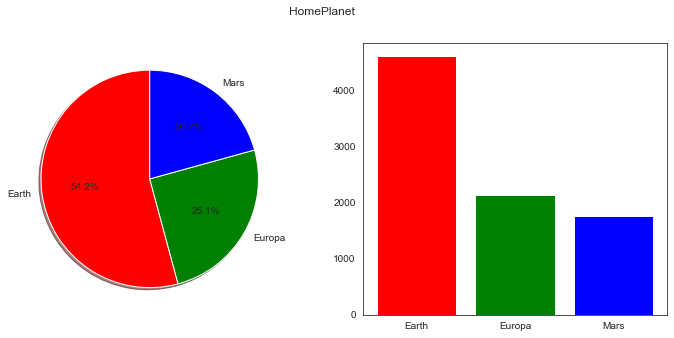

In [11]:
t = df.HomePlanet.value_counts()
labels, sizes = t.index, t.to_list()

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].pie(sizes, labels=labels, autopct='%1.1f%%', 
          shadow=True, startangle=90, colors=['r', 'g', 'b'])
ax[1].bar(labels, sizes, color=['r', 'g', 'b'])

# plt.axis('equal')
# plt.title('Piechart of CryoSleep')

plt.suptitle('HomePlanet')
plt.show()

#### `CryoSleep`
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

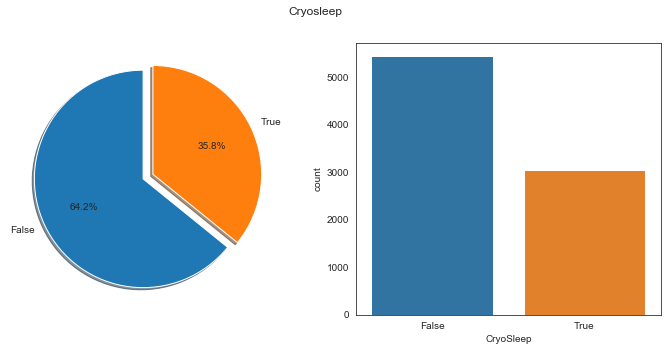

In [12]:
t = df.CryoSleep.value_counts()
labels, sizes = t.index, t.to_list()
explode = (0, 0.1)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
          shadow=True, startangle=90)
sns.countplot(df.CryoSleep, ax=ax[1])

# plt.axis('equal')
# plt.title('Piechart of CryoSleep')

plt.suptitle('Cryosleep')
plt.show()

#### `Cabin`
The cabin number where the passenger is staying. Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.

In [13]:
# Breaking Cabin into deck, num and side
decks, nums, sides = [], [], []
lists = [decks, nums, sides]
for _, row in df.iterrows():
    if pd.isna(row.Cabin):
        for l in lists:
            l.append(np.nan)
    else:
        x = row.Cabin.split('/')
        for i, l in enumerate(lists):
            l.append(x[i])

df['Deck'] = decks
df['Num'] = nums
df['Side'] = sides

# Typecasting num values to int wherever possible, else keeping nan
df['Num'] = df.Num.apply(lambda x: int(x) if not pd.isna(x) else np.nan)

##### `Deck`

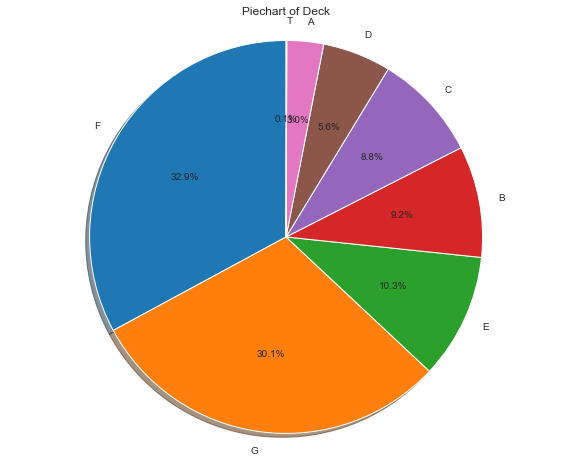

In [14]:
t = df.Deck.value_counts()
labels, sizes = t.index, t.to_list()

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Piechart of Deck')
plt.show()

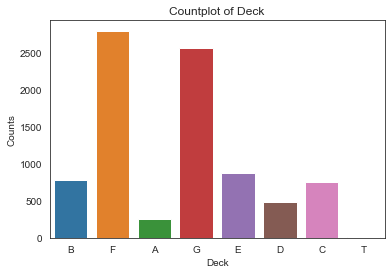

In [15]:
sns_countplot('Deck') if MODE == 'G' else px_countplot('Deck')

##### `Num`
Number of occupants of the cabin

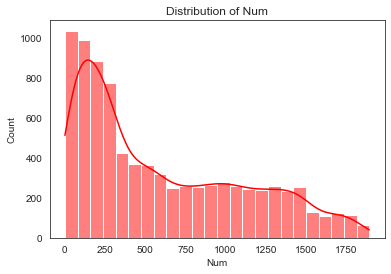

In [16]:
sns_histplot('Num') if MODE == 'G' else px_histplot('Num', nbins=40)

##### `Side`
At which side of the ship the cabin was located.
* `P` implies **Port**
* `S` implies **Starboard**

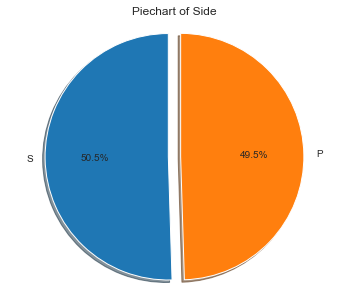

In [17]:
t = df.Side.value_counts()
labels, sizes = t.index, t.to_list()
explode = (0, 0.1)

plt.figure(figsize=(6, 5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Piechart of Side')
plt.show()

#### `Destination`
The planet the passenger will be debarking to.

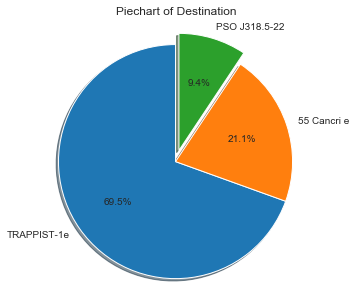

In [18]:
t = df.Destination.value_counts()
labels, sizes = t.index, t.to_list()
explode = (0, 0, 0.1)

plt.figure(figsize=(6, 5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Piechart of Destination')
plt.show()

#### `Age`
The age of the passenger.

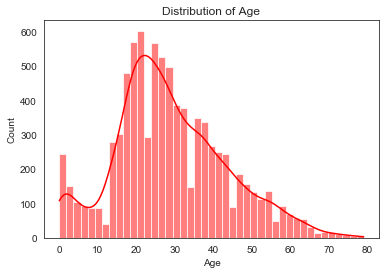

In [19]:
sns_histplot('Age') if MODE == 'G' else px_histplot('Age', nbins=35)

#### `VIP`
Whether the passenger has paid for special VIP service during the voyage.

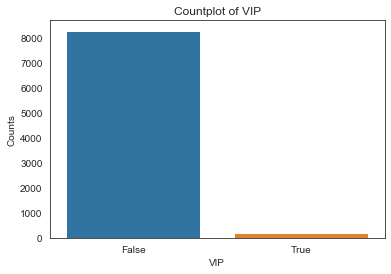

In [20]:
sns_countplot('VIP') if MODE == 'G' else px_countplot('VIP')

#### `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`

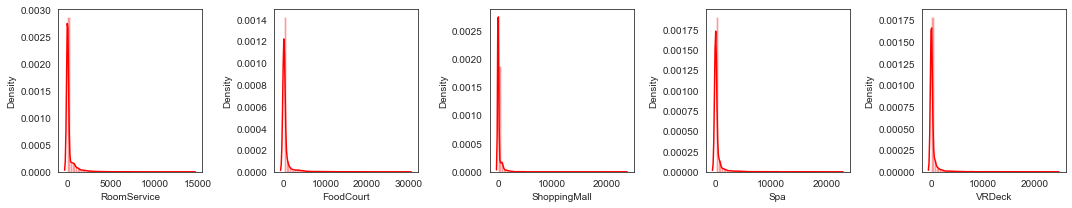

In [21]:
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

sns.distplot(a=df['RoomService'], color='red', ax=axs[0])
sns.distplot(a=df['FoodCourt'], color='red', ax=axs[1])
sns.distplot(a=df['ShoppingMall'], color='red', ax=axs[2])
sns.distplot(a=df['Spa'], color='red', ax=axs[3])
sns.distplot(a=df['VRDeck'], color='red', ax=axs[4])

plt.tight_layout()

#### `Transported`
Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

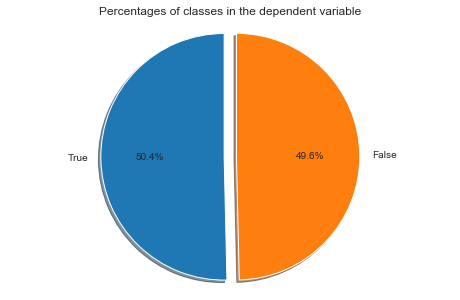

In [22]:
t = df.Transported.value_counts()
labels, sizes = t.index, t.to_list()
explode = (0.1, 0)

plt.figure(figsize=(8, 5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Percentages of classes in the dependent variable')
plt.show()

## Missing Value Analysis

Let's see the percentages of nulls in the columns...

In [23]:
strings = [
    '|#|Column|Percentage of nulls|Type|',
    '|:|:-----|:------------------|:---|'
]
for idx, c in enumerate(df.columns, start=1):
    missing_c = df[pd.isna(df[c])]
    strings.append('|{}|{}|{}%|`{}`|'.format(
        idx, c, round((missing_c.shape[0] / num[0]) * 100, 3),
        'Continuous' if df[c].nunique() > 10 else 'Categorical'
    ))

display(Markdown('\n'.join(strings)))

|#|Column|Percentage of nulls|Type|
|:|:-----|:------------------|:---|
|1|PassengerId|0.0%|`Categorical`|
|2|HomePlanet|2.312%|`Categorical`|
|3|CryoSleep|2.496%|`Categorical`|
|4|Cabin|2.289%|`Continuous`|
|5|Destination|2.094%|`Categorical`|
|6|Age|2.059%|`Continuous`|
|7|VIP|2.335%|`Categorical`|
|8|RoomService|2.082%|`Continuous`|
|9|FoodCourt|2.105%|`Continuous`|
|10|ShoppingMall|2.393%|`Continuous`|
|11|Spa|2.105%|`Continuous`|
|12|VRDeck|2.163%|`Continuous`|
|13|Name|2.301%|`Continuous`|
|14|Transported|0.0%|`Categorical`|
|15|GroupId|0.0%|`Continuous`|
|16|Deck|2.289%|`Categorical`|
|17|Num|2.289%|`Continuous`|
|18|Side|2.289%|`Categorical`|

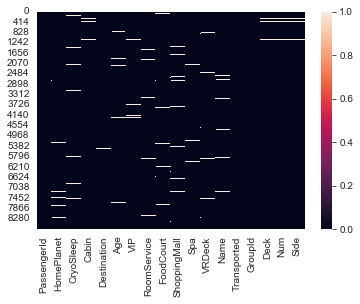

In [24]:
sns.heatmap(pd.isna(df))

### [FEATURE ENGINEERING] `LastName`

In [25]:
def get_last_name(name: str) -> str:
    if pd.isna(name): return ''
    else: return name.split(' ')[1]

In [26]:
df['LastName'] = df.Name.apply(lambda x: get_last_name(x))

In [27]:
df.head(3)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0          01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1          01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2          01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
0          0.0        0.0           0.0     0.0     0.0  Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0     Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0    Altark Susent   

   Transported GroupId Deck  Num Side   LastName  
0        False    0001    B  0.0    P  Ofracculy  
1         True    0002    F  0.0    S      Vines  
2        False    0003    A  0.0    S     Susent

### [TYPECASTING] `GroupId` to `int`

In [28]:
df.GroupId = df.GroupId.apply(lambda x: int(x))

### Writing necessary methods

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
def get_encoder_dictionary(df: pd.DataFrame, encode_cols: List[str], **kwargs) -> Dict[str, LabelEncoder]:
    encoders: Dict[str, LabelEncoder] = {}
    
    # For every column we're fitting the encoder
    # with all non null values and save it in the
    # encoders dictionary with the key `column`
    for column in encode_cols:
        l = LabelEncoder(**kwargs)
        non_null_values: List[Any] = df[~pd.isna(df[column])][column].tolist()
        l.fit(non_null_values)
        encoders[column] = l
    
    return encoders

In [31]:
def test_model(X, y, model, type_, target, ax):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    if type_ == 'C':
        sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='.0f', 
                    ax=ax, linewidth=2, cbar=False)
        ax.set_title('[{}] Confusion-matrix (Accuracy: {})'.format(
            target, accuracy_score(y_test, preds), fontsize=50
        ))
    else:
        mse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        sm.qqplot(y_test-preds, fit=True, line='45', ax=ax, markersize=10)
        ax.set_title('[{}] QQ-Plot (RMSE: {} - MAE: {})'.format(
            target, round(np.sqrt(mse), 3), round(mae, 3)
        ))
    return

In [32]:
# Columns to exclude
exclude_cols = ['PassengerId', 'Cabin', 'Name', 'Transported']

def impute_with_model(
    df: pd.DataFrame,
    target: str,
    encoders: Dict[str, LabelEncoder],
    type_: str = 'C',
    test: bool = True,
    ax=None
) -> pd.DataFrame:

    # Exit condition
    if df[pd.isna(df[target])].shape[0] == 0:
        return df
    
    model = DecisionTreeClassifier() if type_ == 'C' else LinearRegression()
    # Columns that're to be used for this model
    include_cols = [x for x in df.columns if x not in exclude_cols]
    
    # Making a copy of the dataframe
    temp = df[include_cols].copy(deep=True)
    temp.dropna(inplace=True)
    
    for c in temp.columns:
        if c in encoders:
            temp[c] = encoders[c].transform(temp[c])
    
    X, y = (temp[[x for x in df.columns if x not in exclude_cols + [target]]], 
            temp[target])
    
    # NOT WORKING CURRENTLY
    if test and ax:
        f = test_model(X, y, model, type_, target, ax)

    # Final training
    model.fit(X, y)
    # Processing the entire dataframe for prediction
    X_new = df[pd.isna(df[target])][X.columns].dropna()
    # Selecting only those rows
#     X_new = X_new[X.columns].dropna()
    
    # Encoding values for prediction
    for column, encoder in encoders.items():
        if column in X_new.columns:
            X_new[column] = encoder.transform(X_new[column])
    # Making predictions
    preds = model.predict(X_new)
    labels = encoders[target].inverse_transform(preds) if (
        type_ == 'C'
    ) else df[target].tolist()
    # Adding the predictions to respective columns
    idx_preds_mapping: List[Tuple[int, str]] = list(zip(X_new.index.tolist(), labels))
    for idx, p in idx_preds_mapping:
        df.loc[df.index==idx, target] = p
    # For the rest of the missing attributes we're imputing with mode or 
    # median depending on the type of var
    x = df[target].mode().iloc[0] if type_ == 'C' else df[target].median()
    df.loc[pd.isna(df[target]), target] = x
    return df


### Filling up missing values

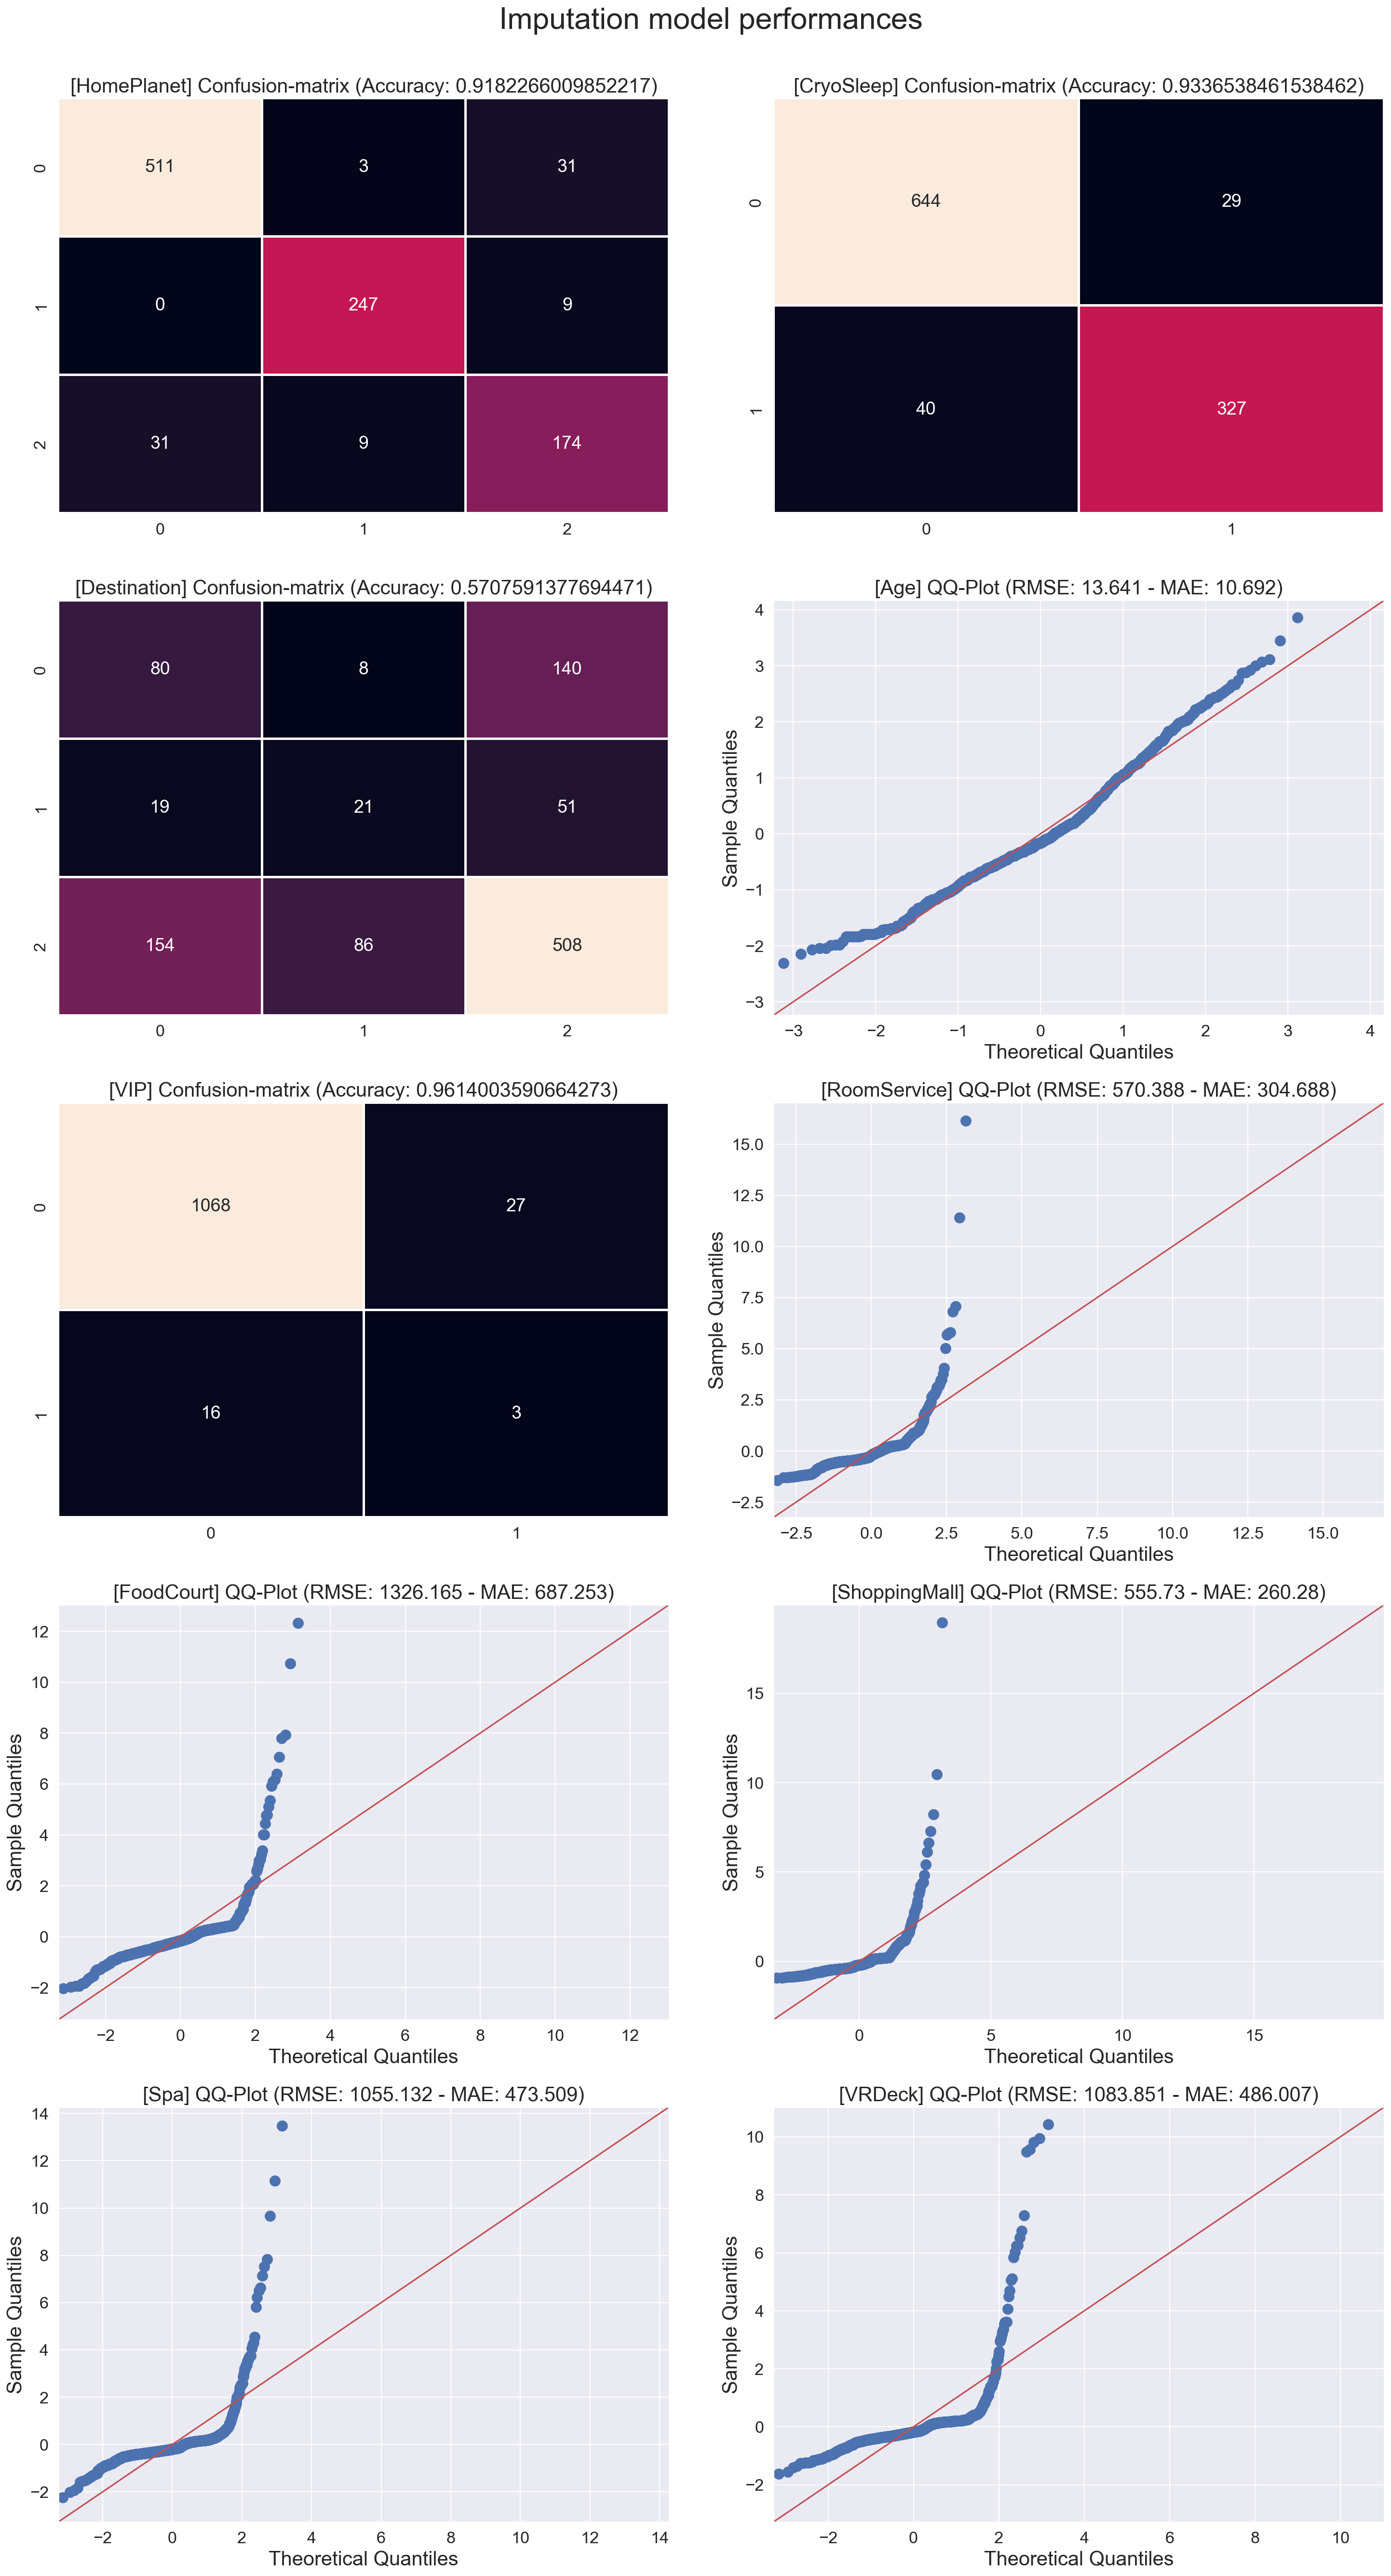

In [33]:
encoder_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Deck', 'Side', 'LastName']
encoders = get_encoder_dictionary(df, encoder_cols)

NROWS, NCOLS = 5, 2
sns.set(font_scale=1.5)
_, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, dpi=150, figsize=(20, 35))

# Columns that we'd have to impute
cols_to_impute = [
    ('HomePlanet', 'C'), ('CryoSleep', 'C'), ('Destination', 'C'),
    ('Age', 'R'), ('VIP', 'C'), ('RoomService', 'R'), ('FoodCourt', 'R'), 
    ('ShoppingMall', 'R'), ('Spa', 'R'), ('VRDeck', 'R')
]

idx = 0
for i in range(NROWS):
    for j in range(NCOLS):
        col, type_ = cols_to_impute[idx]
        df = impute_with_model(df, col, encoders, type_, test=True, ax=ax[i][j])
        ax[i][j].title.set_fontsize(20)
        ax[i][j].xaxis.label.set_fontsize(20)
        ax[i][j].yaxis.label.set_fontsize(20)
        idx += 1

plt.suptitle('Imputation model performances', x=0.5, y=1.02, fontsize=30)
plt.tight_layout()

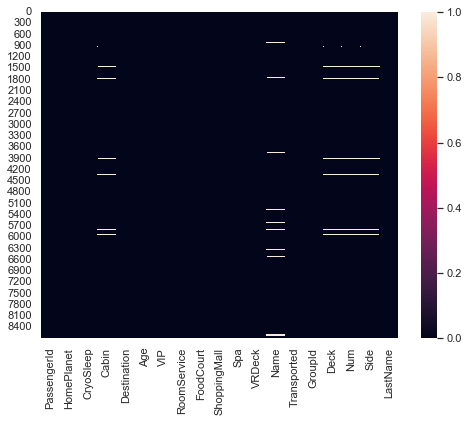

In [34]:
sns.set(font_scale=1)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.isna(df))

## Feature engineering

### Creating new attribute `TotalSpent`

Using the attributes `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` to compute the `TotalSpent` values.

In [35]:
df['TotalSpent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(
    lambda x: sum(x),
    axis=1
)

## Bivariate Analysis

In [36]:
df.head(3)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0          01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1          01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2          01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
0          0.0        0.0           0.0     0.0     0.0  Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0     Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0    Altark Susent   

   Transported  GroupId Deck  Num Side   LastName  TotalSpent  
0        False        1    B  0.0    P  Ofracculy         0.0  
1         True        2    F  0.0    S      Vines       736.0  
2        False        3    A  0.0    S     Susent     10383.0

### Some contingency tables

In [37]:
def contingency_table(col1, col2, ret=True, show=False, transpose=False, **kwargs) -> str:
    temp = pd.crosstab(
        df[col1], df[col2]
    )
    if transpose: temp = temp.T
    sns.heatmap(
        temp, annot=True, fmt='.0f', **kwargs
    )
    if show:
        plt.show()
    return f'Contingency table for {col1} & {col2}'

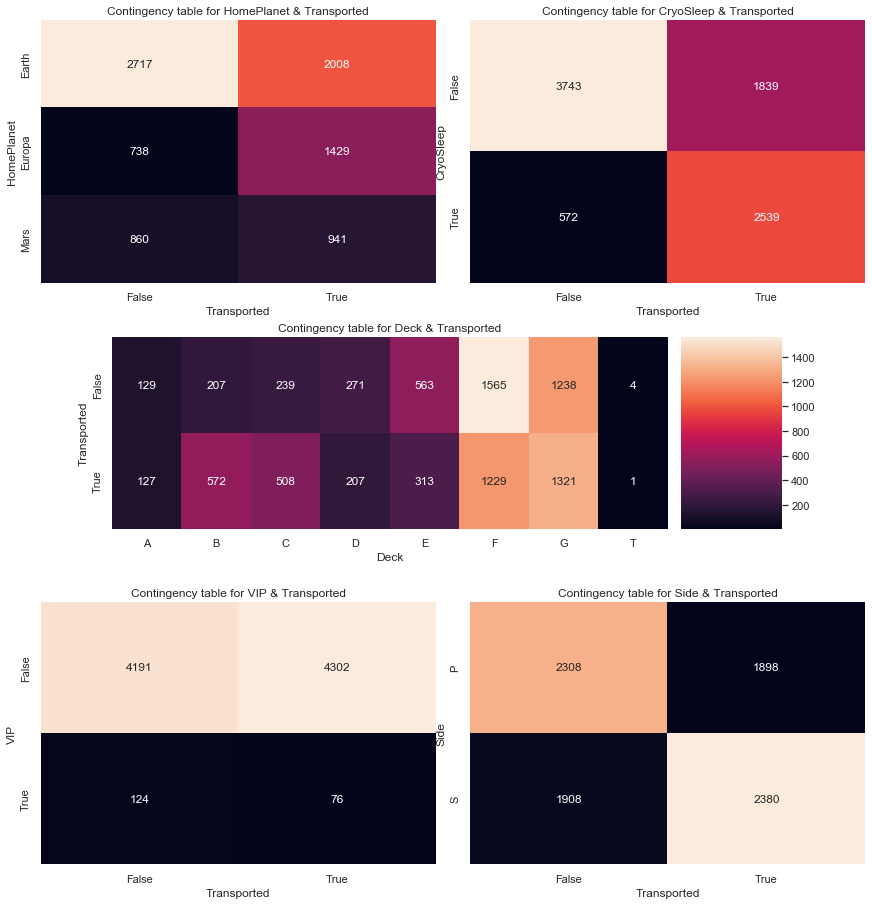

In [38]:
fig = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = fig.add_gridspec(3, 2)

a0 = fig.add_subplot(gs[0,0])
s = contingency_table('HomePlanet', 'Transported', ax=a0, cbar=False)
a0.set_title(s)

a1 = fig.add_subplot(gs[0,1])
s = contingency_table('CryoSleep', 'Transported', ax=a1, cbar=False)
a1.set_title(s)

a2 = fig.add_subplot(gs[1,:])
s = contingency_table('Deck', 'Transported', ax=a2, transpose=True)
a2.set_title(s)

a3 = fig.add_subplot(gs[2, 0])
s = contingency_table('VIP', 'Transported', ax=a3, cbar=False)
a3.set_title(s)


a4 = fig.add_subplot(gs[2, 1])
s = contingency_table('Side', 'Transported', ax=a4, cbar=False)
a4.set_title(s)

plt.show()

Jointplot of 

### Jointplot of `RoomService` and `FoodCourt`

<Figure size 1080x1080 with 0 Axes>

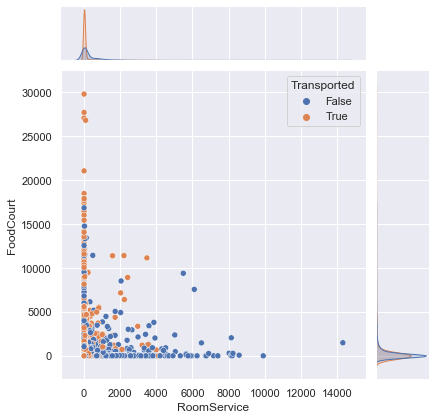

In [39]:
plt.figure(figsize=(15, 15))

sns.jointplot('RoomService', 'FoodCourt', data=df, hue='Transported')

### Values of `VIP` and mean of other attributes

RoomService    FoodCourt  ShoppingMall         Spa       VRDeck  \
VIP                                                                      
False   219.608619   426.462616    170.848463  300.345696   279.997881   
True    462.260000  1806.770000    245.055000  775.735000  1261.480000   

             Age  
VIP               
False  28.618392  
True   37.435000

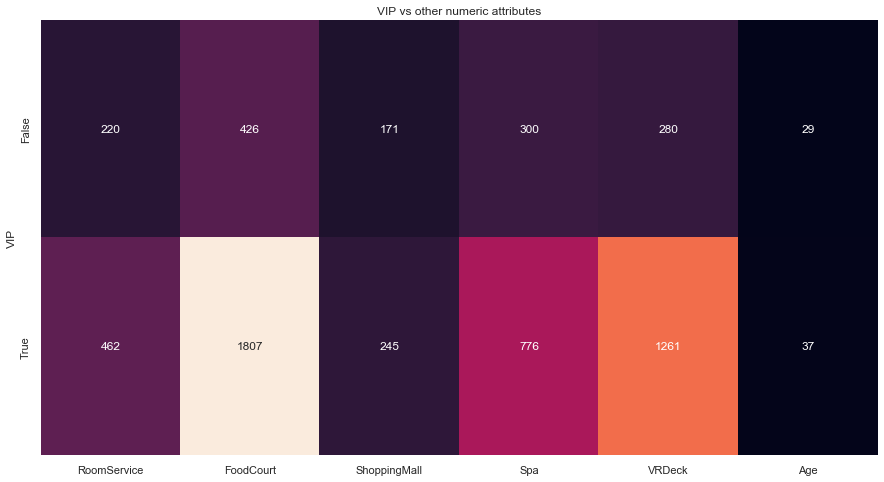

In [40]:
plt.figure(figsize=(15, 8))

vip_gb = df.groupby('VIP').mean()
vip_gb = vip_gb[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']]

sns.heatmap(vip_gb, annot=True, fmt='.0f', cbar=False)
plt.title('VIP vs other numeric attributes')

vip_gb

In [41]:
df.head().style.background_gradient(cmap="Pastel1")

### Correlation

In [42]:
df.corr()

Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.061933   0.123639      0.031116  0.117750   
RoomService   0.061933     1.000000  -0.017474      0.048984  0.007979   
FoodCourt     0.123639    -0.017474   1.000000     -0.011177  0.220333   
ShoppingMall  0.031116     0.048984  -0.011177      1.000000  0.011872   
Spa           0.117750     0.007979   0.220333      0.011872  1.000000   
VRDeck        0.098469    -0.020243   0.221513     -0.006367  0.144554   
Transported  -0.073909    -0.237761   0.043825      0.009058 -0.213565   
GroupId      -0.007898     0.001215  -0.009858      0.015256 -0.005787   
Num          -0.129014    -0.008451  -0.180012      0.000168 -0.127939   
TotalSpent    0.179168     0.232596   0.742267      0.219980  0.592588   

                VRDeck  Transported   GroupId       Num  TotalSpent  
Age           0.098469    -0.073909 -0.007898 -0.129014    0.179168  
RoomService  -0.020243    -0.237761  0.001215 -0.008451    0.232596  
FoodCourt     0.221513     0.043825 -0.009858 -0.180012    0.742267  
ShoppingMall -0.006367     0.009058  0.015256  0.000168    0.219980  
Spa           0.144554    -0.213565 -0.005787 -0.127939    0.592588  
VRDeck        1.000000    -0.201695  0.015604 -0.136467    0.582556  
Transported  -0.201695     1.000000  0.021491 -0.045097   -0.197245  
GroupId       0.015604     0.021491  1.000000  0.679723    0.001873  
Num          -0.136467    -0.045097  0.679723  1.000000   -0.212093  
TotalSpent    0.582556    -0.197245  0.001873 -0.212093    1.000000

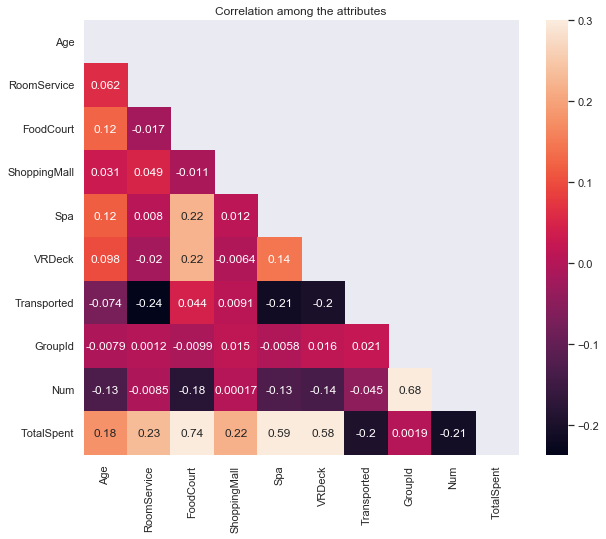

In [43]:
corr = np.corrcoef(np.random.randn(10, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), square=True, linewidths=0, vmax=.3, annot=True, mask=mask)

plt.title('Correlation among the attributes')
plt.show()

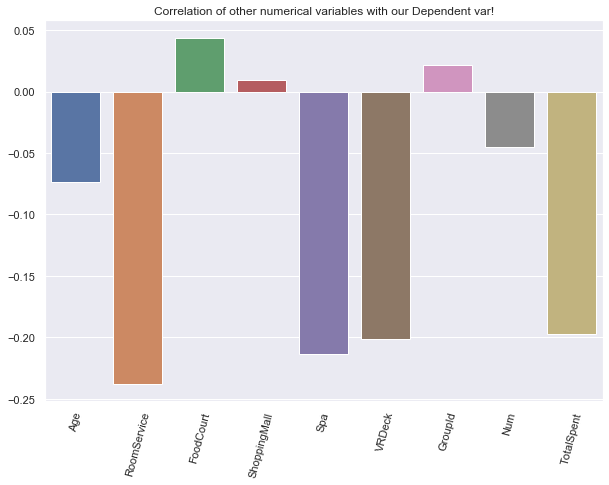

In [44]:
temp = df.corr().Transported
temp = temp[temp.index != 'Transported']
plt.figure(figsize=(10, 7))
sns.barplot(x=temp.index, y=temp.tolist())
plt.xticks(rotation=75)
plt.title('Correlation of other numerical variables with our Dependent var!')
plt.show()

## Predictive Modelling

In [45]:
# Imports
from sklearn.metrics import f1_score, recall_score, precision_score

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#### Fixing the missing values for one final time...

In [46]:
strings = [
    '|#|Column|Percentage of nulls|Type|',
    '|:|:-----|:------------------|:---|'
]
for idx, c in enumerate(df.columns, start=1):
    missing_c = df[pd.isna(df[c])]
    strings.append('|{}|{}|{}%|`{}`|'.format(
        idx, c, round((missing_c.shape[0] / num[0]) * 100, 3),
        'Continuous' if df[c].nunique() > 10 else 'Categorical'
    ))

display(Markdown('\n'.join(strings)))

|#|Column|Percentage of nulls|Type|
|:|:-----|:------------------|:---|
|1|PassengerId|0.0%|`Categorical`|
|2|HomePlanet|0.0%|`Categorical`|
|3|CryoSleep|0.0%|`Categorical`|
|4|Cabin|2.289%|`Continuous`|
|5|Destination|0.0%|`Categorical`|
|6|Age|0.0%|`Continuous`|
|7|VIP|0.0%|`Categorical`|
|8|RoomService|0.0%|`Continuous`|
|9|FoodCourt|0.0%|`Continuous`|
|10|ShoppingMall|0.0%|`Continuous`|
|11|Spa|0.0%|`Continuous`|
|12|VRDeck|0.0%|`Continuous`|
|13|Name|2.301%|`Continuous`|
|14|Transported|0.0%|`Categorical`|
|15|GroupId|0.0%|`Continuous`|
|16|Deck|2.289%|`Categorical`|
|17|Num|2.289%|`Continuous`|
|18|Side|2.289%|`Categorical`|
|19|LastName|0.0%|`Continuous`|
|20|TotalSpent|0.0%|`Continuous`|

Since we aren'y concerned with the `Name` attributes anyways, we can ignore that, but for the `Deck`, `Num` and `Side` we'll be using the central tendencies to impute them, so as not to lose any rows.

In [47]:
df.loc[pd.isna(df.Deck), 'Deck'] = df.Deck.mode().iloc[0]
df.loc[pd.isna(df.Num), 'Num'] = df.Num.mode().iloc[0]
df.loc[pd.isna(df.Side), 'Side'] = df.Side.mode().iloc[0]

#### Encoding the values for modelling

Typecasting `PassengerId` to integer

In [48]:
df.PassengerId = df.PassengerId.apply(lambda x: int(x))

In [49]:
data = df.copy(deep=True)

for column, encoder in encoders.items():
    data[column] = encoder.transform(data[column])

In [50]:
# Attributes that we don't need
UNUSABLE = ['Cabin', 'Name', 'TotalSpent']
DEPENDENT = 'Transported'

In [51]:
X = data.drop(UNUSABLE+[DEPENDENT], axis=1).copy(deep=True)
y = data[DEPENDENT]

In [52]:
X.sample(10).style.background_gradient(cmap="Pastel1")

#### Train test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [54]:
# Method

performances = []

def show_confusion_matrix(conf_matrix, **kwargs):
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1.7)
    sns.heatmap(conf_matrix, annot=True, cbar=False, fmt='.0f', **kwargs)
    sns.set(font_scale=1)

def getModelReport(model, X_test, y_test, msg=np.nan) :

    preds = model.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    precision = precision_score(preds, y_test)
    recall = recall_score(preds, y_test)
    f1 = f1_score(preds, y_test)
    conf_matrix = confusion_matrix(preds, y_test)
    clf_report = classification_report(preds, y_test)
    model_class = model.__class__.__name__
    
    # Saving the performances
    performances.append(
        [model_class, accuracy, f1, msg]
    )
    
    print('*'*60)
    print('{}'.format(model_class).rjust(40, ' '))
    print('*'*60)
    print('ACCURACY:', accuracy)
    print('F1 SCORE:', f1)
    print('CLASSIFICATION REPORT: ')
    print(clf_report)
    print('*'*60)
    
    show_confusion_matrix(conf_matrix)
    plt.title('Confusion matrix of {}'.format(model_class))
    plt.show()

### K-Nearest Neighbors

In [55]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

************************************************************
                    KNeighborsClassifier
************************************************************
ACCURACY: 0.7372052903967797
F1 SCORE: 0.7493143170597916
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       794
           1       0.78      0.72      0.75       945

    accuracy                           0.74      1739
   macro avg       0.74      0.74      0.74      1739
weighted avg       0.74      0.74      0.74      1739

************************************************************


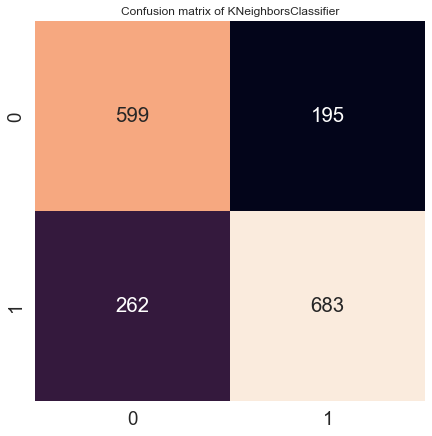

In [56]:
getModelReport(knn, X_test, y_test)

#### Improvements

Firstly we need a reliable number of neighbors, Using Elbow method, well inverted that is!

In [57]:
accuracies, f1scores, ns = [], [], list(range(2, 20))

for n_neighbor in ns:
    k = KNeighborsClassifier(n_neighbor)
    k.fit(X_train, y_train)
    p = k.predict(X_test)
    accuracies.append(accuracy_score(p, y_test))
    f1scores.append(f1_score(p, y_test))
    print(f'{n_neighbor}/19 neighbors', end='\r', flush=True)

In [58]:
adf = pd.DataFrame(list(zip(ns, accuracies, ['Accuracy'] * len(ns))),
                   columns='N Value Type'.split())
fdf = pd.DataFrame(list(zip(ns, f1scores, ['F1Scores'] * len(ns))),
                   columns='N Value Type'.split())

d = pd.concat([adf, fdf]).reset_index(drop=True)

In [59]:
fig = px.line(d, x='N', y='Value', color='Type', markers=True)
fig.update_traces(line=dict(width=2.5),
                  marker=dict(size=10))
fig.show()

************************************************************
                    KNeighborsClassifier
************************************************************
ACCURACY: 0.7446808510638298
F1 SCORE: 0.7602591792656588
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       765
           1       0.80      0.72      0.76       974

    accuracy                           0.74      1739
   macro avg       0.74      0.75      0.74      1739
weighted avg       0.75      0.74      0.75      1739

************************************************************


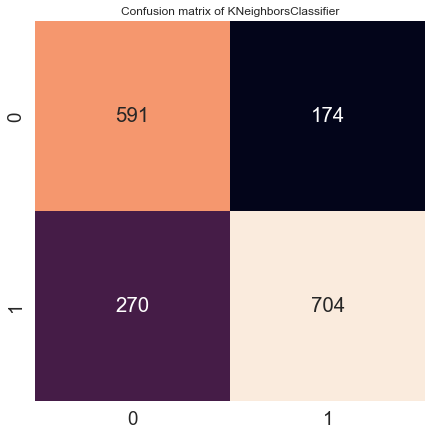

In [60]:
# Using the model with n_neighbour 7

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

getModelReport(knn, X_test, y_test, msg='n_neighbors=7')

### Logistic Regression

In [61]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

************************************************************
                      LogisticRegression
************************************************************
ACCURACY: 0.7688326624496837
F1 SCORE: 0.7746636771300448
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       833
           1       0.79      0.76      0.77       906

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739

************************************************************


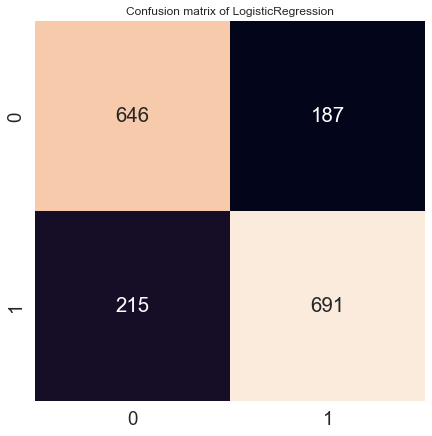

In [62]:
getModelReport(logreg, X_test, y_test)

#### Improvements

In [63]:
# logreg_grid = GridSearchCV(
#     LogisticRegression(),
#     param_grid={'penalty': ['l2', 'elasticnet'],
#                 'tol': [1e-4, 1e-3, 1e-2, 1e-6],
#                 'C': [.01, 0.5, 1],
#                 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
#     verbose=True,
#     n_jobs=-1
# )

In [64]:
# logreg_grid.fit(X_train, y_train)

Best Param found was:

```python
{
    'C': 0.01, 
    'penalty': 'l2', 
    'solver': 'newton-cg', 
    'tol': 0.0001
}
```
with the score `0.7927821710999281`

In [65]:
params = {
    'C': 0.01, 
    'penalty': 'l2', 
    'solver': 'newton-cg', 
    'tol': 0.0001
}

logreg2 = LogisticRegression(**params)
logreg2.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

************************************************************
                      LogisticRegression
************************************************************
ACCURACY: 0.7682576193214491
F1 SCORE: 0.7825148407987048
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       764
           1       0.83      0.74      0.78       975

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739

************************************************************


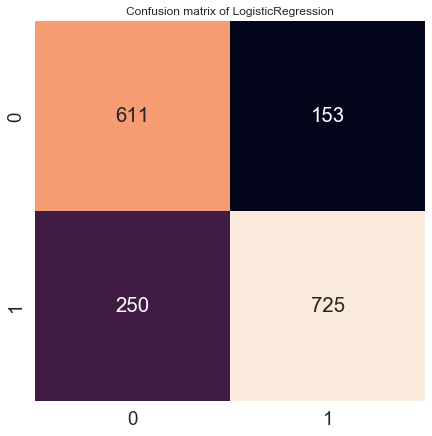

In [66]:
getModelReport(logreg2, X_test, y_test, msg=str(params))

### Decision Tree

In [67]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

************************************************************
                  DecisionTreeClassifier
************************************************************
ACCURACY: 0.7314548591144335
F1 SCORE: 0.73778775968557
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       836
           1       0.75      0.73      0.74       903

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.73      1739
weighted avg       0.73      0.73      0.73      1739

************************************************************


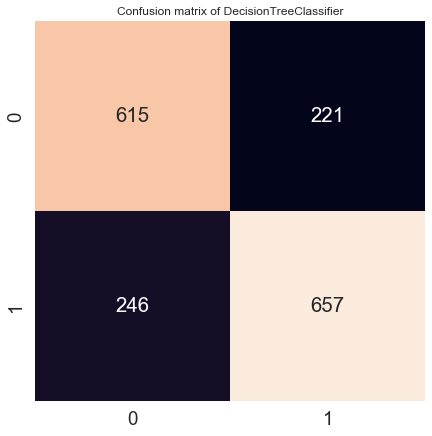

In [68]:
getModelReport(dtree, X_test, y_test)

### Random Forest

In [69]:
rfor = RandomForestClassifier()
rfor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

************************************************************
                  RandomForestClassifier
************************************************************
ACCURACY: 0.7872340425531915
F1 SCORE: 0.7871116225546604
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       879
           1       0.78      0.80      0.79       860

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

************************************************************


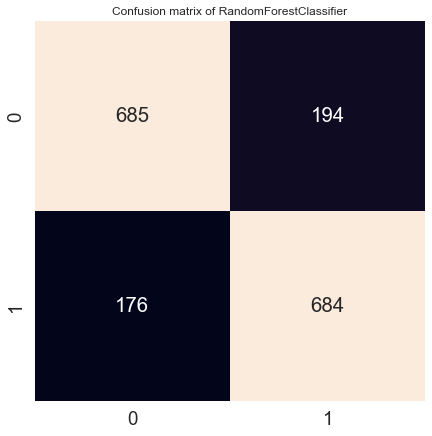

In [70]:
getModelReport(rfor, X_test, y_test)

### Naive Bayes classifier

In [71]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

************************************************************
                              GaussianNB
************************************************************
ACCURACY: 0.6986774008050604
F1 SCORE: 0.7560521415270018
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.47      0.86      0.61       469
           1       0.92      0.64      0.76      1270

    accuracy                           0.70      1739
   macro avg       0.70      0.75      0.68      1739
weighted avg       0.80      0.70      0.72      1739

************************************************************


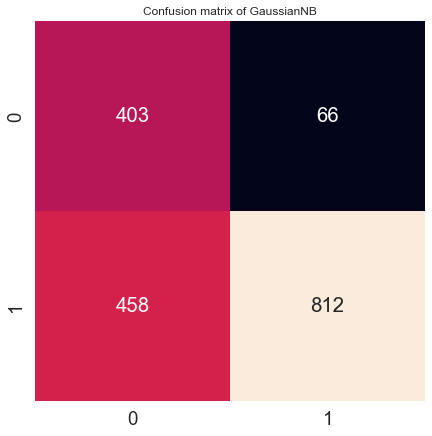

In [72]:
getModelReport(gauss, X_test, y_test)

### Multi-layer perceptron

In [73]:
percep = MLPClassifier()
percep.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

************************************************************
                           MLPClassifier
************************************************************
ACCURACY: 0.5629672225416906
F1 SCORE: 0.2748091603053436
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      1569
           1       0.16      0.85      0.27       170

    accuracy                           0.56      1739
   macro avg       0.57      0.69      0.48      1739
weighted avg       0.89      0.56      0.65      1739

************************************************************


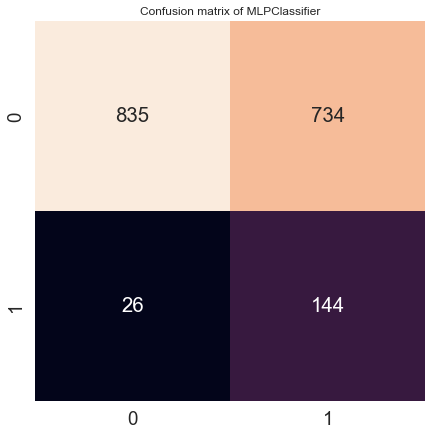

In [74]:
getModelReport(percep, X_test, y_test)

### Support Vector Classifier

In [75]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

************************************************************
                                     SVC
************************************************************
ACCURACY: 0.7682576193214491
F1 SCORE: 0.7936507936507935
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.65      0.84      0.74       664
           1       0.88      0.72      0.79      1075

    accuracy                           0.77      1739
   macro avg       0.77      0.78      0.76      1739
weighted avg       0.79      0.77      0.77      1739

************************************************************


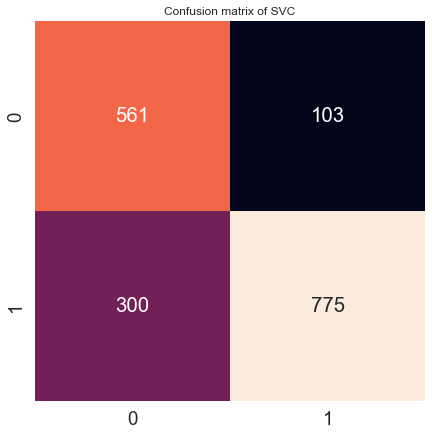

In [76]:
getModelReport(svc, X_test, y_test)

### AdaBoost

In [77]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

************************************************************
                      AdaBoostClassifier
************************************************************
ACCURACY: 0.7745830937320299
F1 SCORE: 0.7834254143646407
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       807
           1       0.81      0.76      0.78       932

    accuracy                           0.77      1739
   macro avg       0.77      0.78      0.77      1739
weighted avg       0.78      0.77      0.77      1739

************************************************************


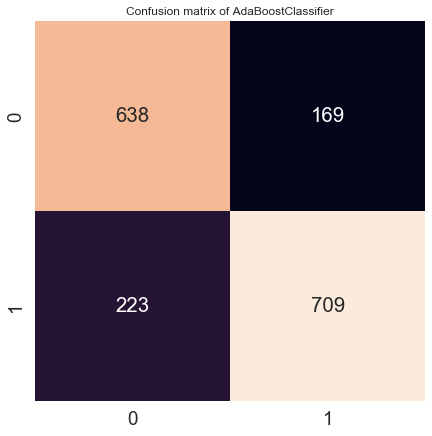

In [78]:
getModelReport(ada, X_test, y_test)

### Bagging

In [79]:
bag = BaggingClassifier()
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

************************************************************
                       BaggingClassifier
************************************************************
ACCURACY: 0.7757331799884991
F1 SCORE: 0.7673031026252983
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       941
           1       0.73      0.81      0.77       798

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

************************************************************


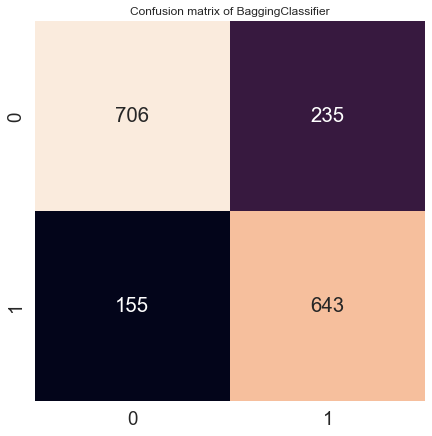

In [80]:
getModelReport(bag, X_test, y_test)

### GradientBoostingClassifier

In [81]:
grad = GradientBoostingClassifier()
grad.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

************************************************************
              GradientBoostingClassifier
************************************************************
ACCURACY: 0.7929844738355377
F1 SCORE: 0.8032786885245902
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       787
           1       0.84      0.77      0.80       952

    accuracy                           0.79      1739
   macro avg       0.79      0.80      0.79      1739
weighted avg       0.80      0.79      0.79      1739

************************************************************


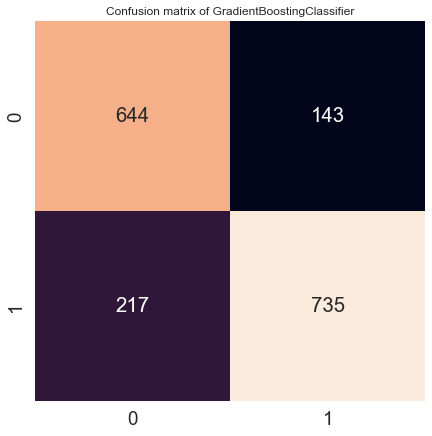

In [82]:
getModelReport(grad, X_test, y_test)

Comparing the performances...

In [83]:
perf = pd.DataFrame(
    performances,
    columns='Model Accuracy F1 Message'.split()
)

In [84]:
perf

Model  Accuracy        F1  \
0         KNeighborsClassifier  0.737205  0.749314   
1         KNeighborsClassifier  0.744681  0.760259   
2           LogisticRegression  0.768833  0.774664   
3           LogisticRegression  0.768258  0.782515   
4       DecisionTreeClassifier  0.731455  0.737788   
5       RandomForestClassifier  0.787234  0.787112   
6                   GaussianNB  0.698677  0.756052   
7                MLPClassifier  0.562967  0.274809   
8                          SVC  0.768258  0.793651   
9           AdaBoostClassifier  0.774583  0.783425   
10           BaggingClassifier  0.775733  0.767303   
11  GradientBoostingClassifier  0.792984  0.803279   

                                              Message  
0                                                 NaN  
1                                       n_neighbors=7  
2                                                 NaN  
3   {'C': 0.01, 'penalty': 'l2', 'solver': 'newton...  
4                                                 NaN  
5                                                 NaN  
6                                                 NaN  
7                                                 NaN  
8                                                 NaN  
9                                                 NaN  
10                                                NaN  
11                                                NaN

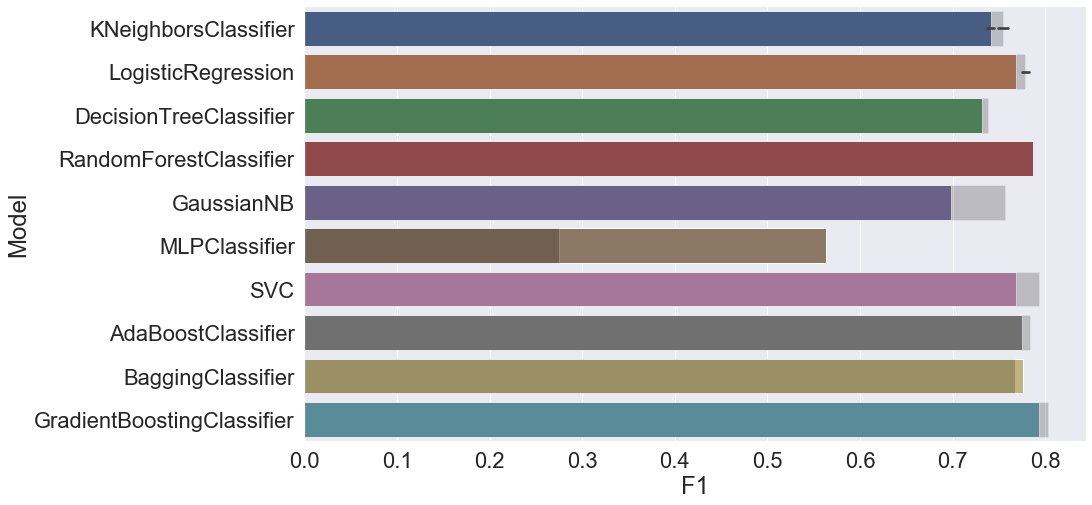

In [85]:
sns.set(font_scale=2)
plt.figure(figsize=(14, 8))
# Accuracies
sns.barplot( y='Model', x='Accuracy', data=perf )
# F1 Scorers
sns.barplot( y='Model', x='F1', data=perf, color='black', alpha=.2 )
plt.show()
sns.set(font_scale=1)

### Neural Networks

#### Simple Keras binary classification model

In [94]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(256, activation="relu", input_shape=(X_train.shape[-1],)),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 136,193
Trainable params: 136,193
Non-trainable params: 0
________________________________________________

In [103]:
# dir(keras.metrics)

In [104]:
metrics = [
    keras.metrics.Accuracy(name='acc'),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

In [105]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

In [107]:
# model.fit(
#     np.array(X_train), y_train.ravel(), epochs=30, verbose=2
# )